In [ ]:
!pip install catboost
!pip install dask[dataframe]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 65.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


<ipython-input-3-d2e2d7d67d4a>:16: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv("/content/household_power_consumption.txt.txt", sep=';', na_values='?', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True)
<ipython-input-3-d2e2d7d67d4a>:16: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv("/content/household_power_consumption.txt.txt", sep=';', na_values='?', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True)
<ipython-input-3-d2e2d7d67d4a>:16: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a

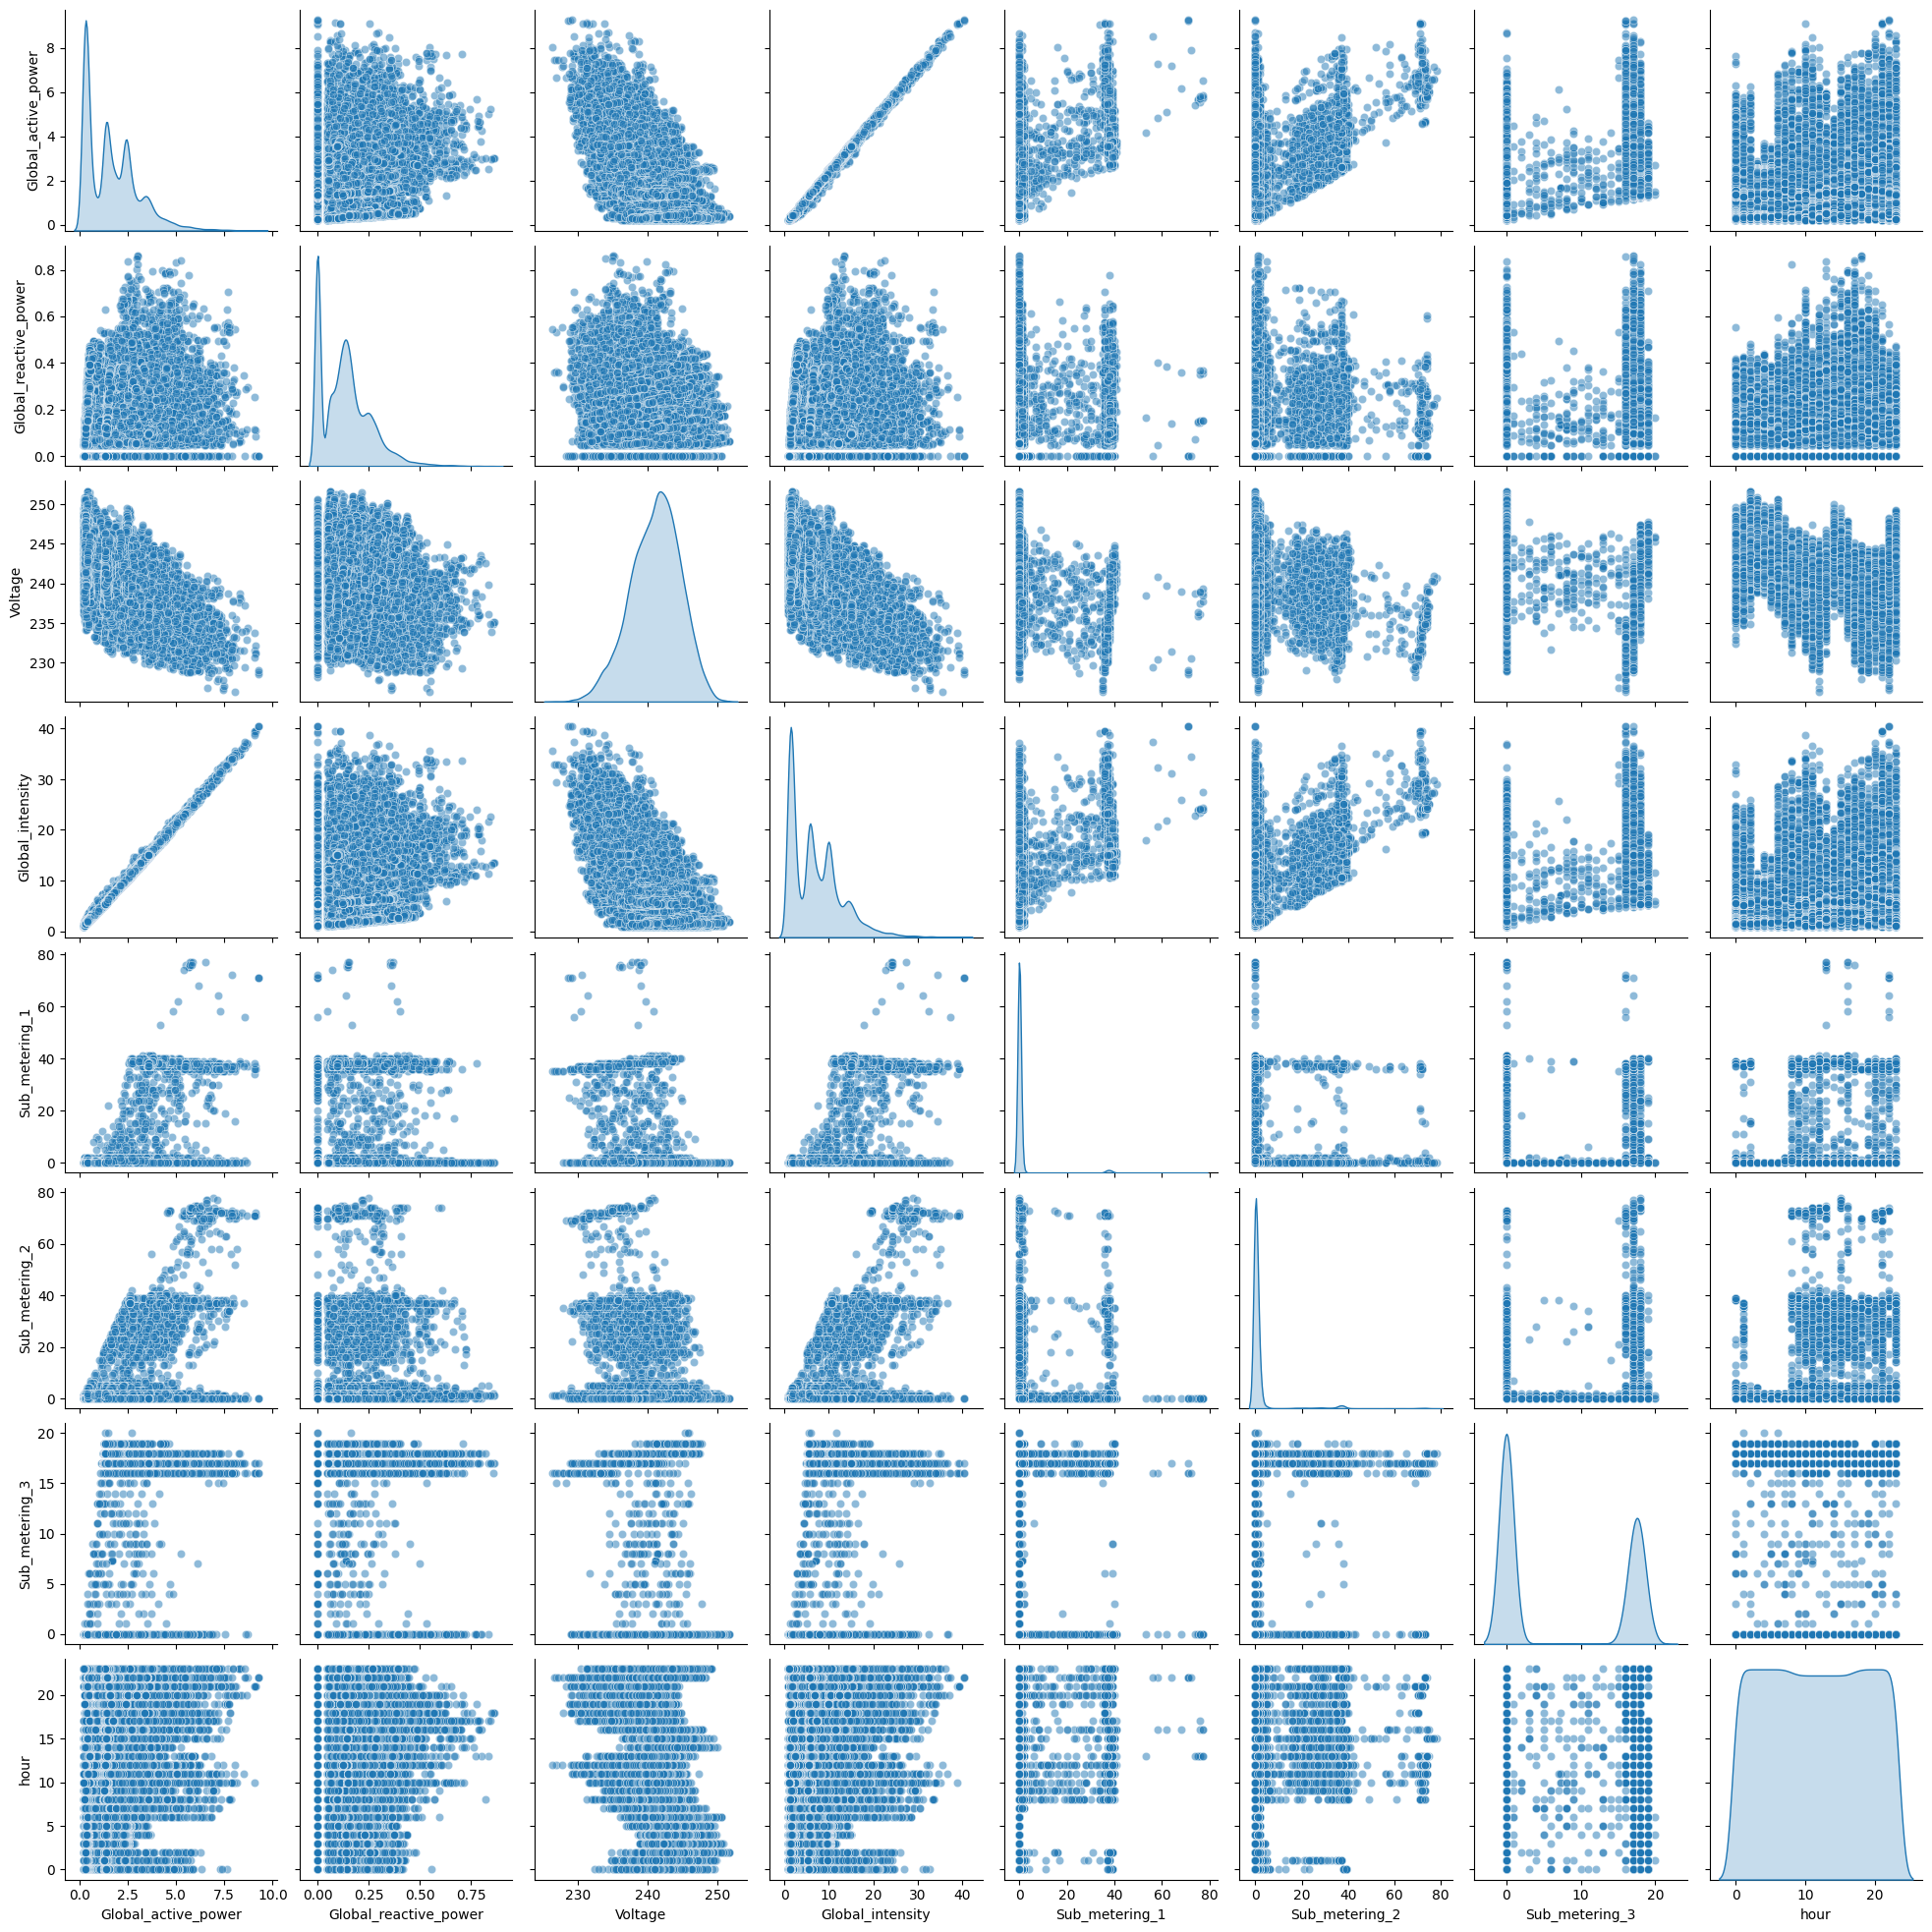

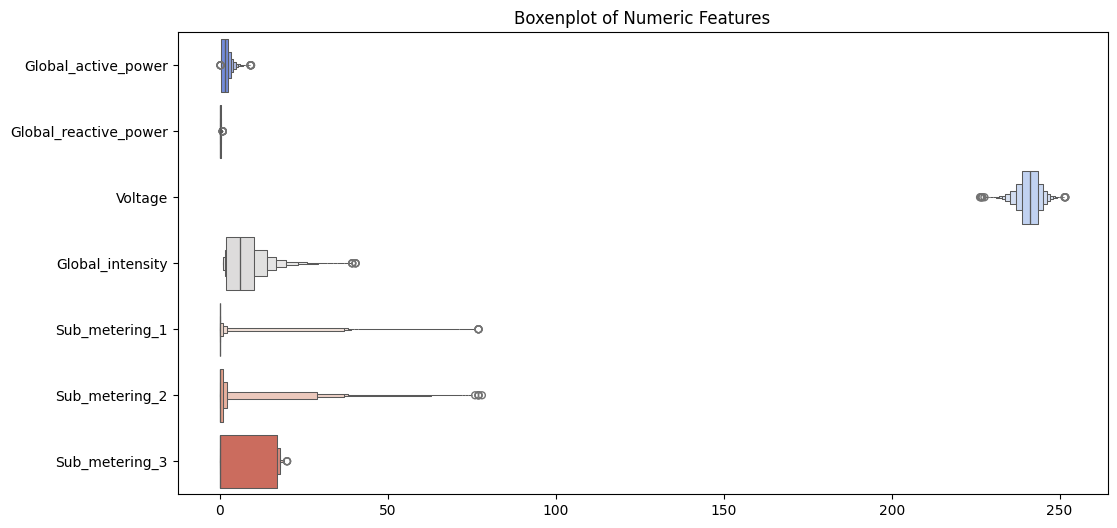

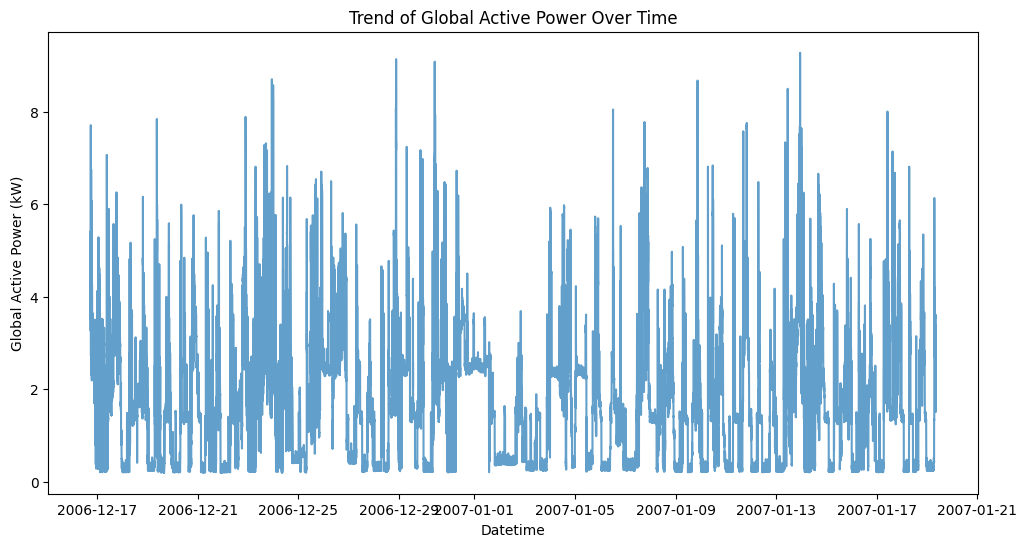

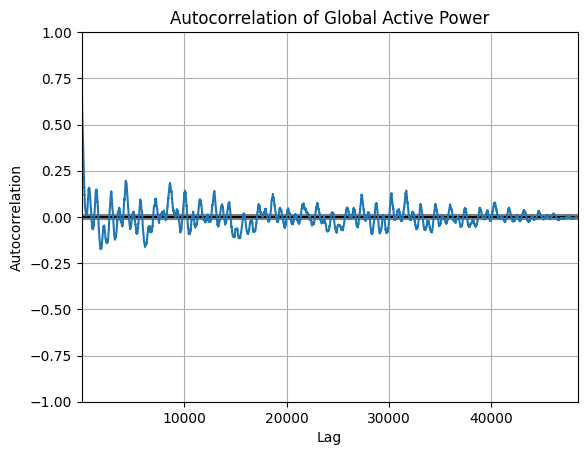

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 33896, number of used features: 8
[LightGBM] [Info] Start training from score 1.688368

Model Evaluation Results:
Ridge Regression - RMSE: 0.06, MAE: 0.04, R²: 1.00
LightGBM - RMSE: 0.04, MAE: 0.02, R²: 1.00
CatBoost - RMSE: 0.04, MAE: 0.02, R²: 1.00


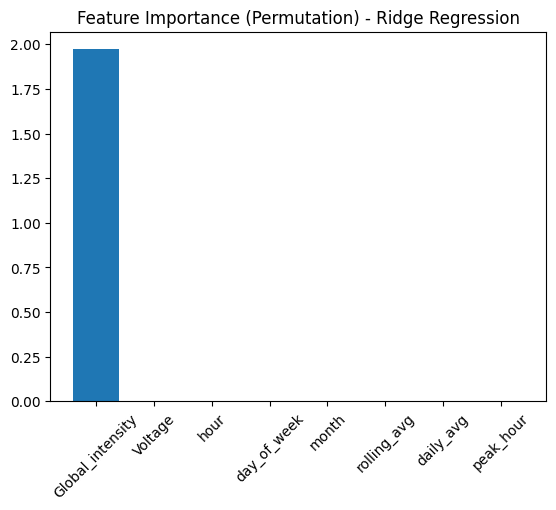

 99%|===================| 14411/14528 [00:43<00:00]       

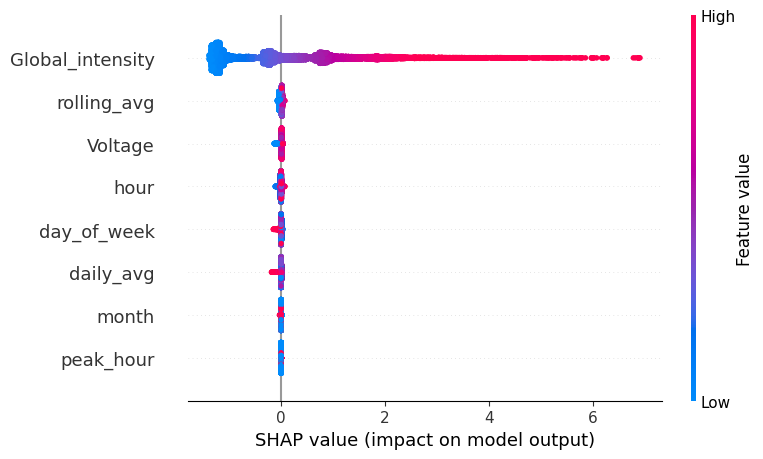

Execution complete.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import shap

# Load the dataset
data = pd.read_csv("/content/household_power_consumption.txt.txt", sep=';', na_values='?', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True)

# Statistical summary
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
                'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Handling Missing Values
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.fillna(data.mean(), inplace=True)

# Parse datetime and create additional features (Feature Engineering)
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek
data['month'] = data['datetime'].dt.month
data['rolling_avg'] = data['Global_active_power'].rolling(window=24, min_periods=1).mean()
data['daily_avg'] = data.groupby(data['datetime'].dt.date)['Global_active_power'].transform('mean')
data['peak_hour'] = data['hour'].apply(lambda x: 1 if 18 <= x <= 22 else 0)

# EDA (Refactored)
# Pairplot for relationships
sns.pairplot(data[numeric_cols + ['hour']], diag_kind='kde', plot_kws={'alpha': 0.5})
plt.show()

# Boxenplot for outlier detection
plt.figure(figsize=(12, 6))
sns.boxenplot(data=data[numeric_cols], orient='h', palette='coolwarm')
plt.title('Boxenplot of Numeric Features')
plt.show()

# Lineplot for trends
plt.figure(figsize=(12, 6))
sns.lineplot(x=data['datetime'], y=data['Global_active_power'], alpha=0.7)
plt.title('Trend of Global Active Power Over Time')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.show()

# Autocorrelation plot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['Global_active_power'].dropna())
plt.title('Autocorrelation of Global Active Power')
plt.show()

# Prepare features and target
features = ['Global_intensity', 'Voltage', 'hour', 'day_of_week', 'month', 'rolling_avg', 'daily_avg', 'peak_hour']
X = data[features]
y = data['Global_active_power']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale data for models requiring scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
# 1. Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

# 2. LightGBM
lgbm_model = LGBMRegressor(random_state=42, n_estimators=100)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)

# 3. CatBoost
catboost_model = CatBoostRegressor(verbose=0, random_state=42, iterations=100)
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)

# Evaluate Models
def evaluate_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

print("\nModel Evaluation Results:")
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
evaluate_model(y_test, y_pred_lgbm, "LightGBM")
evaluate_model(y_test, y_pred_catboost, "CatBoost")

# Feature Importance
# Using Permutation Importance for Ridge
perm_importance = permutation_importance(ridge_model, X_test_scaled, y_test, n_repeats=10, random_state=42)
plt.bar(features, perm_importance.importances_mean)
plt.title('Feature Importance (Permutation) - Ridge Regression')
plt.xticks(rotation=45)
plt.show()

# SHAP for LightGBM
explainer = shap.Explainer(lgbm_model, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

print("Execution complete.")
